In [3]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from ucimlrepo import fetch_ucirepo  # Ensure this package is installed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
# Load dataset
heart_disease = fetch_ucirepo(id=45)

# Extract features and target from the dataset
X = heart_disease.data.features
y = heart_disease.data.targets

# Combine features and target into a single DataFrame
df = pd.concat([X, y], axis=1)

# Assign column names to the DataFrame
column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs',
    'restecg', 'thalach', 'exang', 'oldpeak',
    'slope', 'ca', 'thal', 'num'
]
df.columns = column_names

# Handle Missing Values: Replace '?' and '' with NaN, then convert columns to numeric
df.replace(['?', ''], np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
print(df.isnull().sum())

# Fill missing numerical values with the median of each column
for col in ['ca', 'thal', 'oldpeak', 'slope']:
    df[col].fillna(df[col].median(), inplace=True)

# Simplify the 'num' column to a binary classification target
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df.drop('num', axis=1, inplace=True)

# Convert 'ca' and 'thal' to integer types
df['ca'] = df['ca'].astype(int)
df['thal'] = df['thal'].astype(int)

# Apply One-Hot Encoding to categorical variables
categorical_cols = ['cp', 'restecg', 'slope', 'thal', 'ca']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Separate the features and the target variable for machine learning
X = df.drop('target', axis=1).values
y = df['target'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64


<ipython-input-4-4a0aa4167099>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [5]:
class HeartDiseaseDataset(Dataset):
    def __init__(self, features, targets):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32)  # Binary classification

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
# Create datasets
train_dataset = HeartDiseaseDataset(X_train, y_train)
test_dataset = HeartDiseaseDataset(X_test, y_test)

# Create data loaders
batch_size = 16
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)


In [9]:
class HeartDiseaseModel(nn.Module):
    def __init__(self, input_dim):
        super(HeartDiseaseModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()  # For binary classification
        )

    def forward(self, x):
        return self.network(x)


In [14]:
input_dim = X_train.shape[1]
model = HeartDiseaseModel(input_dim)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 100
patience = 20  # For early stopping
best_loss = np.inf
counter = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).view(-1)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(torch.tensor(X_test, dtype=torch.float32)).view(-1)
        val_loss = criterion(val_outputs, torch.tensor(y_test, dtype=torch.float32)).item()
        val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

# Load the best model
model.load_state_dict(best_model_state)


Epoch [1/100], Train Loss: 0.6994, Val Loss: 0.6959
Epoch [2/100], Train Loss: 0.6829, Val Loss: 0.6814
Epoch [3/100], Train Loss: 0.6755, Val Loss: 0.6686
Epoch [4/100], Train Loss: 0.6641, Val Loss: 0.6540
Epoch [5/100], Train Loss: 0.6513, Val Loss: 0.6413
Epoch [6/100], Train Loss: 0.6448, Val Loss: 0.6283
Epoch [7/100], Train Loss: 0.6270, Val Loss: 0.6134
Epoch [8/100], Train Loss: 0.6208, Val Loss: 0.5994
Epoch [9/100], Train Loss: 0.6112, Val Loss: 0.5856
Epoch [10/100], Train Loss: 0.5962, Val Loss: 0.5718
Epoch [11/100], Train Loss: 0.5782, Val Loss: 0.5569
Epoch [12/100], Train Loss: 0.5788, Val Loss: 0.5428
Epoch [13/100], Train Loss: 0.5658, Val Loss: 0.5276
Epoch [14/100], Train Loss: 0.5604, Val Loss: 0.5140
Epoch [15/100], Train Loss: 0.5273, Val Loss: 0.4991
Epoch [16/100], Train Loss: 0.5261, Val Loss: 0.4842
Epoch [17/100], Train Loss: 0.5212, Val Loss: 0.4699
Epoch [18/100], Train Loss: 0.5093, Val Loss: 0.4551
Epoch [19/100], Train Loss: 0.4986, Val Loss: 0.4420
Ep

<All keys matched successfully>

              precision    recall  f1-score   support

           0       0.93      0.85      0.89        33
           1       0.84      0.93      0.88        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



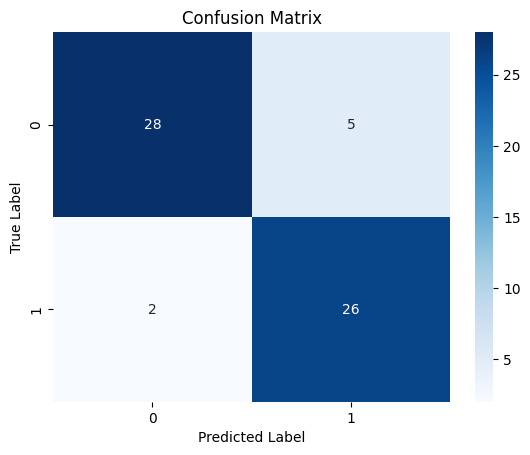

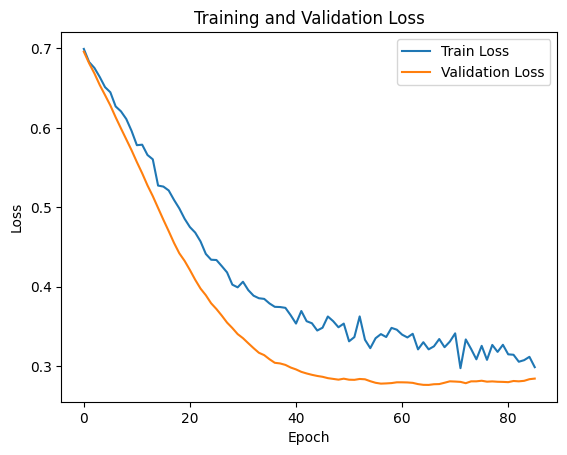

In [15]:
model.eval()
with torch.no_grad():
    y_pred_prob = model(torch.tensor(X_test, dtype=torch.float32)).view(-1).numpy()
    y_pred = (y_pred_prob > 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
